<a href="https://colab.research.google.com/github/biman17/GLOF/blob/master/LDA_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install geopandas
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from osgeo import gdal, ogr, gdalconst
from google.colab import drive
import os
drive.mount('/content/drive')

     |████████████████████████████████| 972kB 2.0MB/s 
     |████████████████████████████████| 10.9MB 11.2MB/s 
     |████████████████████████████████| 14.8MB 252kB/s 
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import math

In [ ]:
basin_shp = gpd.read_file('/content/drive/My Drive/GLOF/Basins_GLOF_Sikkim/HEMA_Basinshp.shp')   
geom_wgs = basin_shp.to_crs(epsg = 4326)
geom = geom_wgs['geometry']

geom_json = geom_wgs.to_json()
print(geom_json)

In [39]:
def arrayToTif(array,tifFilePath,proj,transform,datatype,nodatavalue):
   
    out_ds = gdal.GetDriverByName('GTiff').Create(tifFilePath,
                                                  array.shape[1],
                                                  array.shape[0],
                                                  1,  #Number of bands
                                                  datatype)
    out_ds.SetGeoTransform(transform)
    out_ds.SetProjection(proj)
    out_ds.GetRasterBand(1).WriteArray(array)
    print("Op array stats",np.mean(array),np.median(array),np.max(array))
    out_ds.GetRasterBand(1).SetNoDataValue(nodatavalue)
    # close tif to write into disk (free tif file) 
    out_ds = None

def clip_raster(intif, out_tif, shapefile):
    outtile = gdal.Warp(out_tif,intif,cutlineDSName=shapefile, cropToCutline=True, dstNodata=0)
    outtile = None

def calc_toa_radiance(data_array, band_number):
    radi_mult_band_dict = {1:1.2259E-02, 2:1.2553E-02, 3:1.1567E-02, 4:9.7543E-03, 5:5.9692E-03, 6:1.4845E-03, 7:5.0035E-04, 8:1.1039E-02, 9:2.3329E-03, 10:3.3420E-04, 11:3.3420E-04}
    radi_add_band_dict = {1:-61.29298, 2:-62.76476, 3:-57.83719, 4:-48.77158, 5:-29.84577, 6:-7.42237, 7:-2.50174, 8:-55.19600, 9:-11.66440, 10:0.10000, 11:0.10000}
    return (data_array*radi_mult_band_dict[band_number])+radi_add_band_dict[band_number]

def calc_toa_reflectance(data_array):
    ref_mult = 2.0000E-05
    ref_add = -0.100000
    return (data_array*ref_mult)+ref_add

def toa_brightness_temperature(toa_spe_rad_array, band_number):
    k1_const_dict = {10:774.8853, 11:480.8883}
    k2_const_dict = {10:1321.0789, 11:1201.1442}
    return k2_const_dict[band_number]/(np.log(k1_const_dict[band_number]/toa_spe_rad_array+1))

def calc_NDVI(array_red,array_NIR):
    return (array_NIR.astype(np.float)-array_red.astype(np.float))/(array_NIR.astype(np.float)+array_red.astype(np.float)+0.00001)

def calc_NDMI(band_9, band1):
    return (band_9.astype(np.float)-band1.astype(np.float))/(band_9.astype(np.float)+band1.astype(np.float)+0.00001)

def apply_LDA(NDVI, NDMI, slope, brightness_temp):
    a = NDVI*NDMI
    brightness_temp[brightness_temp<278] = 0
    brightness_temp[brightness_temp>290] = 0
    a= a*brightness_temp

    slope[slope>20] = 0
    a[a<0.04] = 0
    a[a>0.66] = 0

    lake_area = a*slope
    return lake_area



In [ ]:
ds = gdal.Open('/content/drive/My Drive/GLOF_new/DATA/Landsat_oli8/LC08_L1TP_139041_20200819_20200823_01_T1/LC08_L1TP_139041_20200819_20200823_01_T1_B1.TIF')
ds_arr = ds.ReadAsArray()

In [42]:
indir = r"/content/drive/My Drive/GLOF_new/DATA/Landsat_oli8/LC08_L1TP_139041_20200819_20200823_01_T1"
for root, dirs, files in os.walk(indir):
    for filename in files:
        if filename.endswith('_B1.TIF'):
            ds_b1 = gdal.Open(os.path.join(root,filename))
            b1_arr = ds_b1.ReadAsArray()
            b1_arr = calc_toa_reflectance(b1_arr)
        if filename.endswith('_B4.TIF'):
            ds_b4 = gdal.Open(os.path.join(root,filename))
            b4_arr = ds_b4.ReadAsArray()
            b4_arr = calc_toa_reflectance(b4_arr)
        if filename.endswith('_B5.TIF'):
            ds_b5 = gdal.Open(os.path.join(root,filename))
            b5_arr = ds_b5.ReadAsArray()
            b5_arr = calc_toa_reflectance(b5_arr)
        if filename.endswith('_B9.TIF'):
            ds_b9 = gdal.Open(os.path.join(root,filename))
            b9_arr = ds_b9.ReadAsArray()
            b9_arr = calc_toa_reflectance(b9_arr)
        if filename.endswith('_B10.TIF'):
            ds_b10 = gdal.Open(os.path.join(root,filename))
            b10_arr = ds_b10.ReadAsArray()
            b10_arr = calc_toa_radiance(b10_arr, 10)
            b10_bt = toa_brightness_temperature(b10_arr,10)
        if filename.endswith('_B11.TIF'):
            ds_b11 = gdal.Open(os.path.join(root,filename))
            b11_arr = ds_b11.ReadAsArray()          
            b11_arr = calc_toa_radiance(b10_arr, 11)
            b11_bt = toa_brightness_temperature(b11_arr,11)

ndvi = calc_NDVI(b4_arr,b5_arr)
ndmi = calc_NDMI(b9_arr, b10_arr)
slope_ds = gdal.Open('/content/drive/My Drive/GLOF_new/DATA/DEM_ALOS/Slope_Sikkim_reproject.tif')
slope_arr = slope_ds.ReadAsArray()
lake_area = apply_LDA(ndvi,ndmi,slope_arr,b10_bt)

AttributeError: ignored

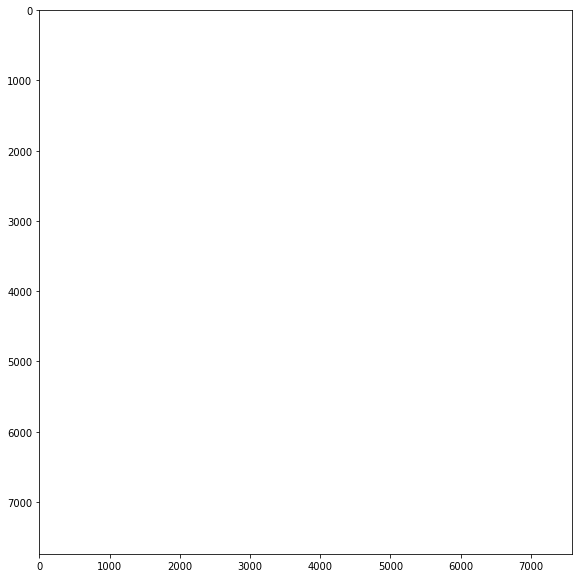

In [34]:
#lake_area[lake_area==0] = np.nan
plt.figure(figsize=(10,10))
plt.imshow(ba_arr)
plt.show()

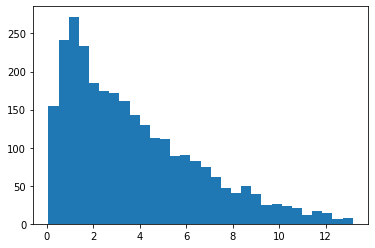

In [37]:
>>> import pylab
>>> pylab.figure()
>>> pylab.hist(lake_area[~np.isnan(lake_area)], bins = 30)
>>> pylab.show()

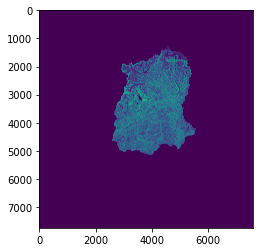

In [24]:
slope_ds = gdal.Open('/content/drive/My Drive/GLOF_new/DATA/DEM_ALOS/Slope_Sikkim_reproject.tif')
slope_arr = slope_ds.ReadAsArray()
plt.imshow(slope_arr)

In [18]:
from osgeo import gdal, gdalconst

inputfile = '/content/drive/My Drive/GLOF_new/DATA/DEM_ALOS/Slope_Sikkim.tif'
input = gdal.Open(inputfile, gdalconst.GA_ReadOnly)
inputProj = input.GetProjection()
inputTrans = input.GetGeoTransform()

referencefile = '/content/drive/My Drive/GLOF_new/DATA/Landsat_oli8/LC08_L1TP_139041_20200819_20200823_01_T1/LC08_L1TP_139041_20200819_20200823_01_T1_B1.TIF'
reference = gdal.Open(referencefile, gdalconst.GA_ReadOnly)
referenceProj = reference.GetProjection()
referenceTrans = reference.GetGeoTransform()
bandreference = reference.GetRasterBand(1)    
x = reference.RasterXSize 
y = reference.RasterYSize


outputfile = '/content/drive/My Drive/GLOF_new/DATA/DEM_ALOS/Slope_Sikkim_reproject.tif'
driver= gdal.GetDriverByName('GTiff')
output = driver.Create(outputfile,x,y,1,bandreference.DataType)
output.SetGeoTransform(referenceTrans)
output.SetProjection(referenceProj)

gdal.ReprojectImage(input,output,inputProj,referenceProj,gdalconst.GRA_Bilinear)

del output

In [ ]:
import folium

geotransform = ds.GetGeoTransform()
cols = ds.RasterXSize
rows = ds.RasterYSize
xmin=geotransform[0]
ymax=geotransform[3]
xmax=xmin+cols*geotransform[1]
ymin=ymax+rows*geotransform[5]

#Get Central point
centerx=(xmin+xmax)/2
centery=(ymin+ymax)/2

m = folium.Map([37, 0], zoom_start=2)

folium.raster_layers.ImageOverlay(
    image=ds_arr,
    bounds=[[ymin, xmin], [ymax, xmax]],
).add_to(m)


In [ ]:
image = toa_ref_b1[1000:2000,1000:2000]


folium.raster_layers.ImageOverlay(
    image=image,
    bounds=[[ymin, xmin], [ymax, xmax]],
).add_to(m)


m